In [1]:
import pandas as pd
import os
os.chdir("C:\\Users\\sandy\\Desktop\\碩一下\\金融大數據\\金融大數據報告")
# 讀取CSV檔案
df= pd.read_csv("鉅亨新聞.csv")

In [2]:
#資料探索
df.dtypes#觀察資料型態
df.info()
df.isna().sum()#檢查有沒有遺失值


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1537 entries, 0 to 1536
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   標題      1537 non-null   object
 1   連結      1537 non-null   object
 2   類別      1537 non-null   object
 3   內容      1537 non-null   object
 4   時間      1537 non-null   object
dtypes: object(5)
memory usage: 60.2+ KB


標題    0
連結    0
類別    0
內容    0
時間    0
dtype: int64

In [3]:
#將日期拆成月份跟時間
# 日期和時間段存儲在名為'時間'的列表中
df['時間'] = pd.to_datetime(df['時間'])

# 提取月份部分並轉換為字符串格式
df['日期'] =df['時間'].dt.strftime('%Y%m%d')

# 提取時間部分並轉換為字符串格式
df['時間'] = df['時間'].dt.strftime('%H:%M')

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns


# 使用 groupby 方法分組並統計每天的新聞數量
article_count = df.groupby('日期').size().reset_index(name='新聞數量').sort_values(by="新聞數量", ascending=False)

#使用 groupby 方法分組並統計不同類別的新聞數量
article_count2 = df.groupby('類別').size().reset_index(name='新聞數量').sort_values(by="新聞數量", ascending=False)

#觀察哪個類別的新聞標題最常提到AI
df[df["標題"].str.contains("AI")]["類別"].value_counts()


台股新聞     42
美股       23
專家觀點     21
美股雷達     19
台股盤勢      5
國際股       3
國際政經      3
鉅亨新視界     2
港股        2
歐亞股       2
大陸政經      1
外匯        1
Name: 類別, dtype: int64

In [5]:
#資料清理
import re

RE_SUSPICIOUS = re.compile(r'[&;#<>{}\[\]\\]')

def impurity(text, min_len=10):
    """returns the share of suspicious characters in a text"""
    if text == None or len(text) < min_len:
        return 0
    else:
        return len(RE_SUSPICIOUS.findall(text))/len(text)


df['impurity'] = df['內容'].apply(impurity, min_len=10)
df[['內容', 'impurity']].sort_values(by='impurity', ascending=False).head(5)





import html

def clean(text):
    # convert html escapes like &amp; to characters.
    text = html.unescape(text)
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)#中括號有跟網址的符號刪除
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)#中括號裡面有文字跟數字清理掉
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of white spaces
    #text=re.sub(r'\s+', '', text)
    text=re.sub(r'/', '', text)
    text = re.sub(r'<[^<>]*>', '', text)#標記式語言刪除
    #text=re.sub(r'[^\w\s]', '', text)
    return text.strip()

df['clean_text'] = df['內容'].map(clean)




from textacy.preprocessing import replace

df['clean_text'] = df['clean_text'].map(replace.urls)
df['clean_text'] = df['clean_text'].map(replace.emails)
df['clean_text'] = df['clean_text'].map(replace.hashtags)
df['clean_text'] = df['clean_text'].map(replace.user_handles)
df['clean_text'] = df['clean_text'].map(replace.hashtags)


#重新計算文章雜訊
df['impurity'] = df['clean_text'].apply(impurity, min_len=10)



#欄位重新命名，並且將雜訊欄位移除
df.rename(columns={'內容': 'Raw_text', 'Clean_text': '內容'}, inplace=True)
df.drop(columns=['impurity'], inplace=True)



#新增欄位
df["length"]=df["clean_text"].str.len()
df.describe().T

#觀察每一個類別新聞內容長度的平均值
result = df.groupby("類別").agg({"length":"mean"}).sort_values(by="length", ascending=False).reset_index()
result_top5 = result.head(5)


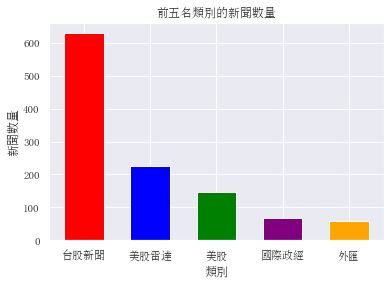

In [7]:

#探索性分析
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font="Simsun")
top5_data = article_count2.nlargest(5, '新聞數量')

# 定義自訂顏色
colors = ['red', 'blue', 'green', 'purple', 'orange']
plt.bar(top5_data['類別'], top5_data['新聞數量'], color=colors, width=0.6)
plt.xlabel('類別')
plt.ylabel('新聞數量')
plt.title('前五名類別的新聞數量')
plt.show()


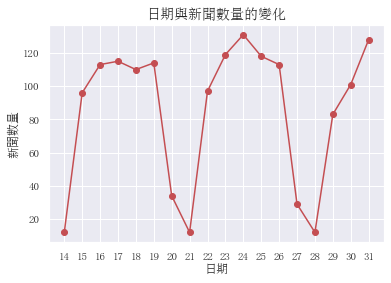

In [8]:
#繪製日期與新聞數量折線圖
article_count['日期'] = pd.to_datetime(article_count['日期'])
# 提取日期欄位的日部分並轉換為字串型態
article_count['日期'] = article_count['日期'].dt.day.astype(str)


import matplotlib.pyplot as plt
# 按照日期欄位進行排序
df_sorted = article_count.sort_values('日期')
# 取得排序後的日期和新聞數量
x = df_sorted['日期']
y = df_sorted['新聞數量']

# 繪製折線圖
plt.plot(x, y,"r-o")

# 設定標籤和標題
plt.xlabel('日期',fontsize=12)
plt.ylabel('新聞數量',fontsize=12)
plt.title('日期與新聞數量的變化',fontsize=14)

# 顯示圖形
plt.show()

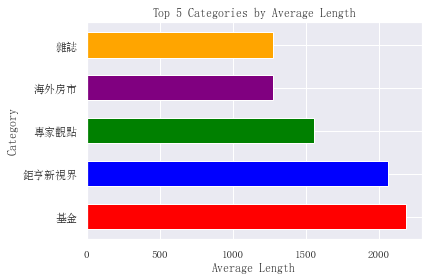

In [9]:
# 創建一個子資料集，僅包含前五個最大值
top_5 = result.head(5)

# 定義顏色列表，與類別數量相符
colors = ['red', 'blue', 'green', 'purple', 'orange']
bar_width=0.6
# 繪製長條圖，指定顏色
plt.barh(top_5["類別"], top_5["length"], color=colors,height=bar_width)

# 添加標題和軸標籤
plt.title("Top 5 Categories by Average Length")
plt.xlabel("Average Length")
plt.ylabel("Category")

# 顯示圖形
plt.show()

In [10]:
#資料探勘分析
import jieba

jieba.set_dictionary('./dict.txt.big.txt')
stopwords1 = [line.strip() for line in open('./stopWords.txt', 'r', encoding='utf-8').readlines()]
def remove_stop(text):
    c1=[]
    for w in text:
        if w not in stopwords1:
            c1.append(w)
    c2=[i for i in c1 if i.strip() != '']
    return c2

Y = df['clean_text']
Y1 = Y[:127].apply(jieba.cut) #5/31號
Y1 = Y[128:228].apply(jieba.cut)#5/30號
Y1 = Y[229:311].apply(jieba.cut)#5/29號
Y1 = Y[312:323].apply(jieba.cut)#5/28號
Y1 =Y[324:352].apply(jieba.cut)#5/27號
Y1 = Y[353:465].apply(jieba.cut)#5/26號
Y1 = Y[466:583].apply(jieba.cut)#5/25號
Y1 = Y[584:714].apply(jieba.cut)#5/24號
Y1 = Y[715:833].apply(jieba.cut)#5/23號
Y1 = Y[834:930].apply(jieba.cut)#5/22號
Y1 =Y[931:942].apply(jieba.cut)#5/21號
Y1 =Y[942:976].apply(jieba.cut)#5/20號
Y1 =Y[977:1090].apply(jieba.cut)#5/19號
Y1 =Y[1091:1200].apply(jieba.cut)#5/18號
Y1 =Y[1201:1316].apply(jieba.cut)#5/17號
Y1 =Y[1316:1429].apply(jieba.cut)#5/16號
Y2 =Y[1429:].apply(jieba.cut)#5/15-14號


from collections import Counter

Y_1 = Y1.apply(remove_stop)
counter = Counter()
Y_1.apply(counter.update)
print(Y1)
print(counter['上漲'])
print(counter['下跌'])
print(counter['台積電'])
print(counter['輝達'])



Building prefix dict from C:\Users\sandy\Desktop\碩一下\金融大數據\金融大數據報告\dict.txt.big.txt ...
Dumping model to file cache C:\Users\sandy\AppData\Local\Temp\jieba.u9d3cddb4e8bf735cae69c3f44e0104e1.cache
Loading model cost 3.177 seconds.
Prefix dict has been built successfully.


1316    <generator object cut at 0x00000154D063FB30>
1317    <generator object cut at 0x00000154D063FBA0>
1318    <generator object cut at 0x00000154D063FC10>
1319    <generator object cut at 0x00000154D063FC80>
1320    <generator object cut at 0x00000154D063FCF0>
                            ...                     
1424    <generator object cut at 0x00000154D0639AC0>
1425    <generator object cut at 0x00000154D0639B30>
1426    <generator object cut at 0x00000154D0639BA0>
1427    <generator object cut at 0x00000154D0639C10>
1428    <generator object cut at 0x00000154D0639C80>
Name: clean_text, Length: 113, dtype: object
82
44
35
6


In [11]:
import pandas as pd

# 假設您的原始資料儲存在名為df的DataFrame中，並且新聞內容在'內文'欄位中
# 利用字串方法contains選取只有提到"台積電"的新聞
filtered_df = df[df['clean_text'].str.contains('輝達')]

# 重設索引
filtered_df.reset_index(drop=True, inplace=True)

# 印出結果
print(filtered_df)


import re

def remove_punctuation(text):
    # 使用正则表达式将标点符号替换为空格
    text = re.sub(r'[^\w\s]', ' ', text)
    # 去除多余的空格
    text = re.sub(r'\s+', '', text)
    # 返回处理后的文本
    return text

filtered_df['clean_text'] = filtered_df['clean_text'].apply(remove_punctuation)

import jieba

jieba.set_dictionary('./dict.txt.big.txt')
stopwords1 = [line.strip() for line in open('./stopWords.txt', 'r', encoding='utf-8').readlines()]

def remove_stop(text):
    c1 = []
    for w in text:
        if w != '輝達' and len(w) > 1 and w not in stopwords1:
            c1.append(w)
    c2 = [i for i in c1 if i.strip() != '']
    return c2

jieba.add_word('輝達')

filtered_df['tokens'] = filtered_df['clean_text'].apply(jieba.cut)
filtered_df['tokens_new'] = filtered_df['tokens'].apply(remove_stop)
print(filtered_df.iloc[0, :])


C:\Users\sandy\AppData\Local\Temp\ipykernel_19004\551904621.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['clean_text'] = filtered_df['clean_text'].apply(remove_punctuation)
Building prefix dict from C:\Users\sandy\Desktop\碩一下\金融大數據\金融大數據報告\dict.txt.big.txt ...
Loading model from cache C:\Users\sandy\AppData\Local\Temp\jieba.u9d3cddb4e8bf735cae69c3f44e0104e1.cache


                                              標題  \
0                             蔡明彰觀點：AI熱潮下個主流：記憶體   
1                        AI迎來大改款/大升級商機! 哪些族群將勝出?   
2                       索取AI類股懶人包！錯過一顆蘋果 不要再錯過AI   
3                     〈聯詠股東會〉SoC也導入AI 應用在安防、車用領域   
4                           輝達過後的AI押寶標的 女股神看好軟體股   
..                                           ...   
131  〈美股13F報告〉明星操盤手Q1動向：Loeb艾克曼敲進Google、泰柏買特斯拉輝達   
132                  〈台股盤前〉大盤難擺脫「五窮六絕」魔咒 整理時間將拉長   
133                  〈美股盤後〉觀望債務上限談判 美股收高 道瓊終止連五黑   
134                            蔡明彰觀點：被忽視的AI伺服器黑馬   
135                                本週台股操作重點及關注族群   

                                               連結    類別  \
0    https://news.cnyes.com/news/id/5197844?exp=a  專家觀點   
1    https://news.cnyes.com/news/id/5197688?exp=a  專家觀點   
2    https://news.cnyes.com/news/id/5198279?exp=a  專家觀點   
3    https://news.cnyes.com/news/id/5197630?exp=a  台股新聞   
4    https://news.cnyes.com/news/id/5197573?exp=a  美股雷達   
..                   

Loading model cost 2.917 seconds.
Prefix dict has been built successfully.
C:\Users\sandy\AppData\Local\Temp\ipykernel_19004\551904621.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['tokens'] = filtered_df['clean_text'].apply(jieba.cut)


標題                                           蔡明彰觀點：AI熱潮下個主流：記憶體
連結                 https://news.cnyes.com/news/id/5197844?exp=a
類別                                                         專家觀點
Raw_text      &lt;p&gt;今天報告的主題是「AI 熱潮下個主流：記憶體」。&lt;/p&gt;\n\...
時間                                                        18:30
日期                                                     20230531
clean_text    今天報告的主題是AI熱潮下個主流記憶體萬寶投顧蔡明彰強調AI狂潮台股三大權值股台積電2330...
length                                                     2680
tokens             <generator object cut at 0x00000154D4C61A50>
tokens_new    [今天, 報告, 主題, AI, 熱潮, 下個, 主流, 記憶體, 萬寶, 投顧, 蔡明彰,...
Name: 0, dtype: object


C:\Users\sandy\AppData\Local\Temp\ipykernel_19004\551904621.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['tokens_new'] = filtered_df['tokens'].apply(remove_stop)


[('AI', 641), ('美國', 320), ('指數', 279), ('上漲', 247), ('市場', 238), ('表示', 216), ('公司', 214), ('晶片', 213), ('預期', 205), ('美元', 188), ('股價', 186), ('今年', 185), ('下跌', 158), ('伺服器', 143), ('億美元', 137)]


Text(0.5, 1.0, '輝達 Top Words')

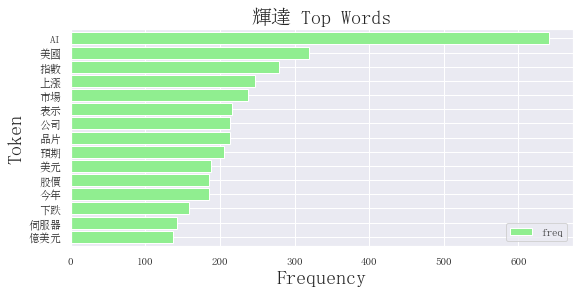

In [12]:
#Freq charts
from collections import Counter
counter = Counter()#use a empty string first
filtered_df['tokens_new'].apply(counter.update)
print(counter.most_common(15))

import seaborn as sns
sns.set(font="SimSun")
min_freq=2
#transform dict into dataframe
freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
freq_df = freq_df.query('freq >= @min_freq')
freq_df.index.name = 'token'
freq_df = freq_df.sort_values('freq', ascending=False)
freq_df.head(15)

ax = freq_df.head(15).plot(kind='barh', width=0.85, figsize=(9,4),color='#90EE90')
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='輝達 Top Words')
ax.set_xlabel('Frequency', fontsize=20)
ax.set_ylabel('Token', fontsize=20)
ax.set_title('輝達 Top Words', fontsize=20)



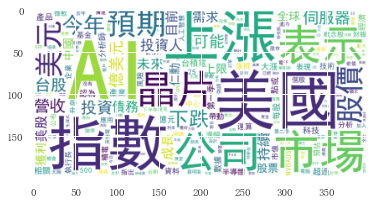

In [14]:
###Creating Word Clouds
from matplotlib import pyplot as plt
from wordcloud import WordCloud ###
from collections import Counter ###

wordcloud = WordCloud(font_path="./SimHei.ttf", background_color="white")
wordcloud.generate_from_frequencies(freq_df['freq'])
#plt.figure(figsize=(20,10)) 
plt.imshow(wordcloud)

In [15]:
#繪製台積電與輝達文字雲
import pandas as pd

# 假設您的原始資料儲存在名為df的DataFrame中，並且新聞內容在'內文'欄位中
# 利用字串方法contains選取只有提到"台積電"的新聞
filtered_df2 = df[df['clean_text'].str.contains('台積電')]

# 重設索引
filtered_df2.reset_index(drop=True, inplace=True)

# 印出結果
print(filtered_df2)

                                     標題  \
0           〈美股早盤〉美債上限法案將在眾院全院表決 主要指數開低   
1                    蔡明彰觀點：AI熱潮下個主流：記憶體   
2         外資連5買卻砍台指期淨多單 加碼航空雙雄、狙擊這五檔金融股   
3               AI迎來大改款/大升級商機! 哪些族群將勝出?   
4              索取AI類股懶人包！錯過一顆蘋果 不要再錯過AI   
..                                  ...   
180                       本週台股操作重點及關注族群   
181               〈台股盤前〉美股持續回檔影響 上漲力道有限   
182  【邱志昌專欄】衰退的實體經濟與停滯的股市：被動與主動式投資何者較佳？   
183           OPPO結束自研晶片業務 回頭採用聯發科、高通晶片   
184           〈台股風向球〉美債上限歹戲拖棚中 個股走勢分道揚鑣   

                                               連結     類別  \
0    https://news.cnyes.com/news/id/5198420?exp=a   美股雷達   
1    https://news.cnyes.com/news/id/5197844?exp=a   專家觀點   
2    https://news.cnyes.com/news/id/5198416?exp=a   台股新聞   
3    https://news.cnyes.com/news/id/5197688?exp=a   專家觀點   
4    https://news.cnyes.com/news/id/5198279?exp=a   專家觀點   
..                                            ...    ...   
180  https://news.cnyes.com/news/id/5178522?exp=a   專家觀點   
181

In [16]:
import re

def remove_punctuation(text):
    # 使用正则表达式将标点符号替换为空格
    text = re.sub(r'[^\w\s]', ' ', text)
    # 去除多余的空格
    text = re.sub(r'\s+', '', text)
    # 返回处理后的文本
    return text

filtered_df2['clean_text'] = filtered_df2['clean_text'].apply(remove_punctuation)

import jieba

jieba.set_dictionary('./dict.txt.big.txt')
stopwords1 = [line.strip() for line in open('./stopWords.txt', 'r', encoding='utf-8').readlines()]

def remove_stop(text):
    c1 = []
    for w in text:
        if w != '台積電' and len(w) > 1 and w not in stopwords1:
            c1.append(w)
    c2 = [i for i in c1 if i.strip() != '']
    return c2

jieba.add_word('台積電')

filtered_df2['tokens'] = filtered_df2['clean_text'].apply(jieba.cut)
filtered_df2['tokens_new'] = filtered_df2['tokens'].apply(remove_stop)
print(filtered_df.iloc[0, :])

C:\Users\sandy\AppData\Local\Temp\ipykernel_19004\2243532338.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df2['clean_text'] = filtered_df2['clean_text'].apply(remove_punctuation)
Building prefix dict from C:\Users\sandy\Desktop\碩一下\金融大數據\金融大數據報告\dict.txt.big.txt ...
Loading model from cache C:\Users\sandy\AppData\Local\Temp\jieba.u9d3cddb4e8bf735cae69c3f44e0104e1.cache
Loading model cost 3.001 seconds.
Prefix dict has been built successfully.
C:\Users\sandy\AppData\Local\Temp\ipykernel_19004\2243532338.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

標題                                           蔡明彰觀點：AI熱潮下個主流：記憶體
連結                 https://news.cnyes.com/news/id/5197844?exp=a
類別                                                         專家觀點
Raw_text      &lt;p&gt;今天報告的主題是「AI 熱潮下個主流：記憶體」。&lt;/p&gt;\n\...
時間                                                        18:30
日期                                                     20230531
clean_text    今天報告的主題是AI熱潮下個主流記憶體萬寶投顧蔡明彰強調AI狂潮台股三大權值股台積電2330...
length                                                     2680
tokens             <generator object cut at 0x00000154D4C61A50>
tokens_new    [今天, 報告, 主題, AI, 熱潮, 下個, 主流, 記憶體, 萬寶, 投顧, 蔡明彰,...
Name: 0, dtype: object


C:\Users\sandy\AppData\Local\Temp\ipykernel_19004\2243532338.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df2['tokens_new'] = filtered_df2['tokens'].apply(remove_stop)


[('AI', 489), ('美國', 377), ('上漲', 377), ('指數', 376), ('億元', 320), ('台股', 290), ('市場', 285), ('美元', 283), ('股價', 266), ('公司', 246), ('下跌', 233), ('投資', 225), ('預期', 218), ('表示', 197), ('持續', 193)]


Text(0.5, 1.0, '台積電 Top Words')

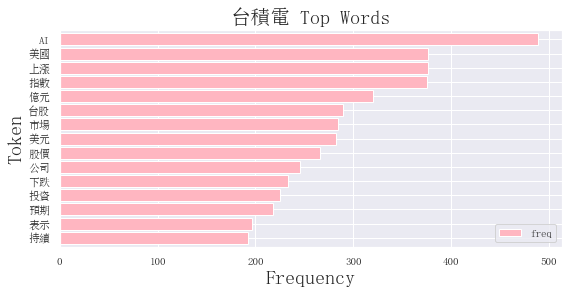

In [17]:
#Freq charts
from collections import Counter
counter = Counter()#use a empty string first
filtered_df2['tokens_new'].apply(counter.update)
print(counter.most_common(15))

import seaborn as sns
sns.set(font="SimSun")
min_freq=2
#transform dict into dataframe
freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
freq_df = freq_df.query('freq >= @min_freq')
freq_df.index.name = 'token'
freq_df = freq_df.sort_values('freq', ascending=False)
freq_df.head(15)

ax = freq_df.head(15).plot(kind='barh', width=0.85, figsize=(9,4),color='#FFB6C1')
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='台積電 Top Words')
ax.set_xlabel('Frequency', fontsize=20)
ax.set_ylabel('Token', fontsize=20)
ax.set_title('台積電 Top Words', fontsize=20)


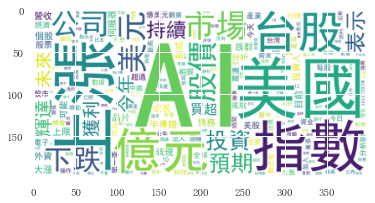

In [18]:
###Creating Word Clouds
from matplotlib import pyplot as plt
from wordcloud import WordCloud ###
from collections import Counter ###

wordcloud = WordCloud(font_path="./SimHei.ttf", background_color="white")
wordcloud.generate_from_frequencies(freq_df['freq'])
#plt.figure(figsize=(20,10)) 
plt.imshow(wordcloud)
